In [3]:
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime
import re
from collections import defaultdict

class MetricsAnalyzer:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.avg_times = defaultdict(list)

    def read_json(self, file_path):
        with open(file_path, 'r') as file:
            return json.load(file)

    def sanitize_filename(self, filename):
        filename = filename.replace(' ', '_')
        filename = re.sub(r'[^\w\-_\.]', '', filename)
        return filename

    def get_params_string(self, params):
        summary = params.get('summary', {})
        ranking = params.get('ranking', {})
        entity = params.get('entity', {})
        relation = params.get('relation', {})

        preprocess_str = f"Preprocess: {params.get('preprocess', None)}" if params.get('preprocess', None) is not None else ''
        summary_method = f"Summary Method: {summary.get('summary_method', None)}" if summary.get('summary_method', None) is not None else ''
        summary_percentage = f"Summary Percentage: {summary.get('summary_percentage', None)}" if summary.get('summary_percentage', None) is not None else ''
        ranking_method = f"Ranking Method: {ranking.get('ranking', None)}" if ranking.get('ranking', None) is not None else ''
        ranking_perc_threshold = f"Ranking Perc Threshold: {ranking.get('ranking_perc_threshold', None)}" if ranking.get('ranking_perc_threshold', None) is not None else ''
        options_ent = f"Options Ent: {', '.join(sorted(entity.get('options_ent', [None])))}" if sorted(entity.get('options_ent', [None])) != [None] else ''
        options_rel = f"Options Rel: {', '.join(sorted(relation.get('options_rel', [None])))}" if sorted(relation.get('options_rel', [None])) != [None] else ''
        local_rm = f"Local RM: {relation.get('local_rm', None)}" if relation.get('local_rm', None) is not None else ''
        rebel_model = f"Rebel Model: {relation.get('rebel_model', None)}" if relation.get('rebel_model', None) is not None else ''
        
        params_list = [preprocess_str, summary_method, summary_percentage, ranking_method, ranking_perc_threshold, options_ent, options_rel, local_rm, rebel_model]
        params_str = '\n'.join(filter(None, params_list))

        return params_str
        
    def calculate_duration(self, start, end):
        start_time = datetime.fromisoformat(start)
        end_time = datetime.fromisoformat(end)
        return (end_time - start_time).total_seconds()

    def normalize_times(self, times, num_files):
        return [time / num_files for time in times]

    def plot_times(self, file_ids, normalized_times, params_str):
        fig_dir = 'plot/time_folder'
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        params_str_clean = params_str.replace('\n', ' ')
        plt.figure(figsize=(10, 6))
        plt.bar(file_ids, normalized_times, color='skyblue')
        plt.xlabel('File ID')
        plt.ylabel('Normalized Time (seconds)')
        plt.title(f'\n{params_str}', fontsize=14, fontweight='bold')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        fig_path = os.path.join(fig_dir, f"{self.sanitize_filename(params_str_clean)}_time_plot.png")
        plt.savefig(fig_path)

    def analyze(self):
        metrics_by_folder = {}
        avg_time_dict = {}
    
        for root, dirs, _ in os.walk(self.root_dir):
            for dir_name in dirs:
    
                metrics_path = os.path.join(root, dir_name, 'metrics.json')
                logs_path = os.path.join(root, dir_name, 'logs.json')
                params_path = os.path.join(root, dir_name, 'params.json')
    
                if all(os.path.exists(p) for p in [metrics_path, logs_path, params_path]):
                    metrics = self.read_json(metrics_path)
                    logs = self.read_json(logs_path)
                    params = self.read_json(params_path)
    
                    params_str = self.get_params_string(params)  # Update params_str here
    
                    times = []
                    file_ids = []
                    for file_id, log in logs.items():
                        if file_id != 'finished':
                            start = log['start']
                            end = log['end']
                            duration = self.calculate_duration(start, end)
                            times.append(duration)
                            file_ids.append(file_id)
    
                    num_files = len(file_ids)
                    normalized_times = self.normalize_times(times, num_files)
                    avg_time = sum(times) / len(times)
                    avg_time_dict[params_str] = avg_time  # Save average time with corresponding parameters
    
        # Select top 10 fastest sets of parameters
        top_10_avg_times = sorted(avg_time_dict.items(), key=lambda x: x[1])[:10]    
        print("Top 10 sets of parameters:")
        for params_str, avg_time in top_10_avg_times:
            print(f"Parameters: {params_str}, Average Time: {avg_time}")
        fig_dir = 'plot/time_folder/top_10_time_folder'
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        params_strs, avg_times = zip(*top_10_avg_times)
        plt.figure(figsize=(12, 8))
        plt.bar(params_strs, avg_times, color='skyblue')
        plt.xlabel('Parameters')
        plt.ylabel('Average Time (seconds)')
        plt.title('Average Time for Top 10 Sets of Parameters')
        plt.xticks(rotation=65, ha='right', fontsize=6)

        plt.tight_layout()
        fig_path = os.path.join(fig_dir, f"top_10_time_plot.png")
        plt.savefig(fig_path)
        plt.show()
        
        for params_str, avg_time in top_10_avg_times:
            params_str_clean = params_str.replace('\n', ' ')
            plt.figure(figsize=(10, 6))
            plt.bar(file_ids, normalized_times, color='skyblue')
            plt.xlabel('File ID')
            plt.ylabel('Normalized Time (seconds)')
            plt.title(f'\n{params_str}', fontsize=14, fontweight='bold')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.xticks(rotation=45)
            plt.tight_layout()
            fig_path = os.path.join(fig_dir, f"{self.sanitize_filename(params_str_clean)}_time_plot.png")
            plt.savefig(fig_path)
            plt.show()


Top 10 sets of parameters:
Parameters: Preprocess: {'preprocess': True, 'spacy_model': 'en_core_web_lg'}
Summary Method: chat-gpt
Summary Percentage: 15
Ranking Method: page_rank
Ranking Perc Threshold: 0.15
Options Rel: corenlp, Average Time: 9.967857421052631
Parameters: Preprocess: {'preprocess': True, 'spacy_model': 'en_core_web_lg'}
Summary Method: chat-gpt
Summary Percentage: 30
Ranking Method: page_rank
Ranking Perc Threshold: 0.15
Options Rel: corenlp, Average Time: 10.205242526315791
Parameters: Preprocess: {'preprocess': True, 'spacy_model': 'en_core_web_lg'}
Summary Method: chat-gpt
Summary Percentage: 15
Ranking Method: page_rank
Ranking Perc Threshold: 0.15
Options Rel: rebel
Local RM: False
Rebel Model: Babelscape/rebel-large, Average Time: 10.228173315789473
Parameters: Preprocess: {'preprocess': True, 'spacy_model': 'en_core_web_lg'}
Summary Method: chat-gpt
Summary Percentage: 30
Ranking Method: page_rank
Ranking Perc Threshold: 0.15
Options Rel: rebel
Local RM: False


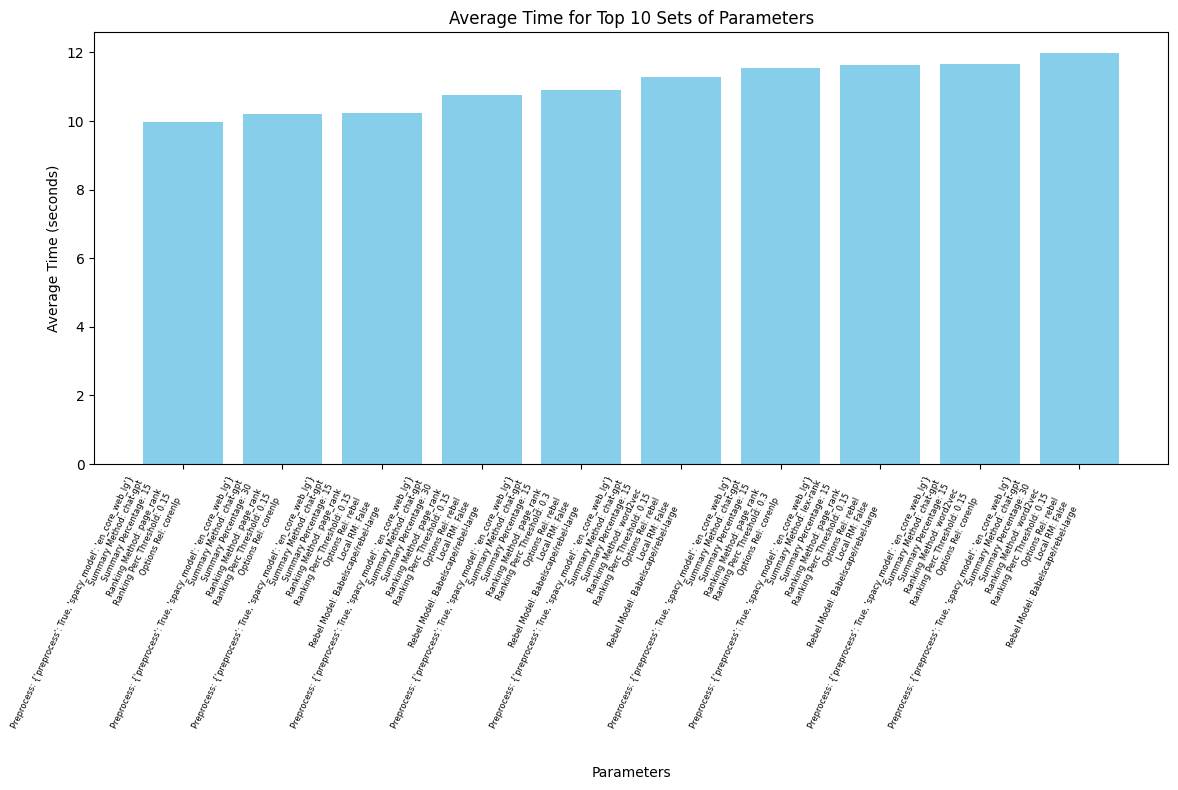

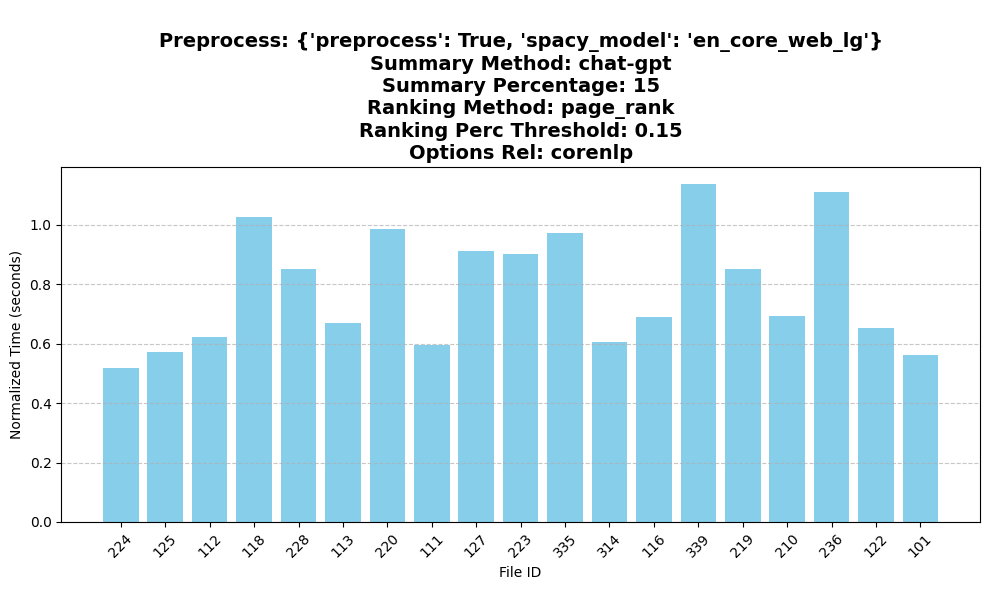

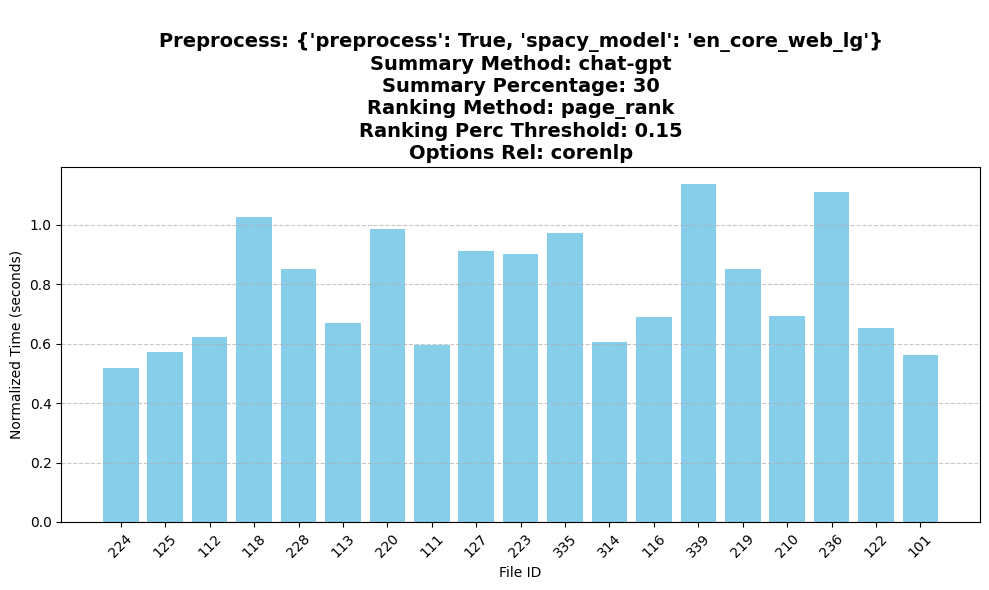

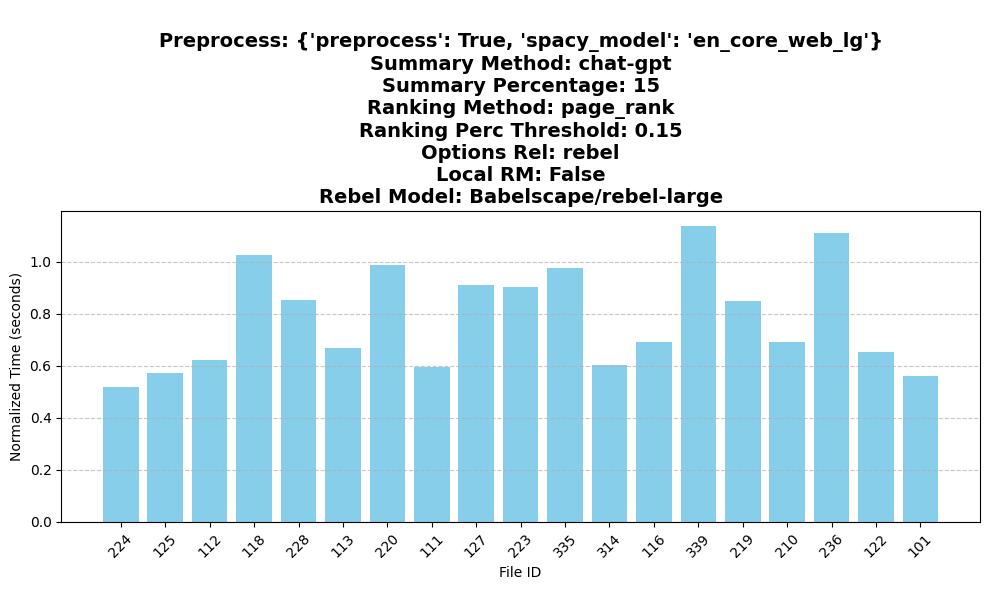

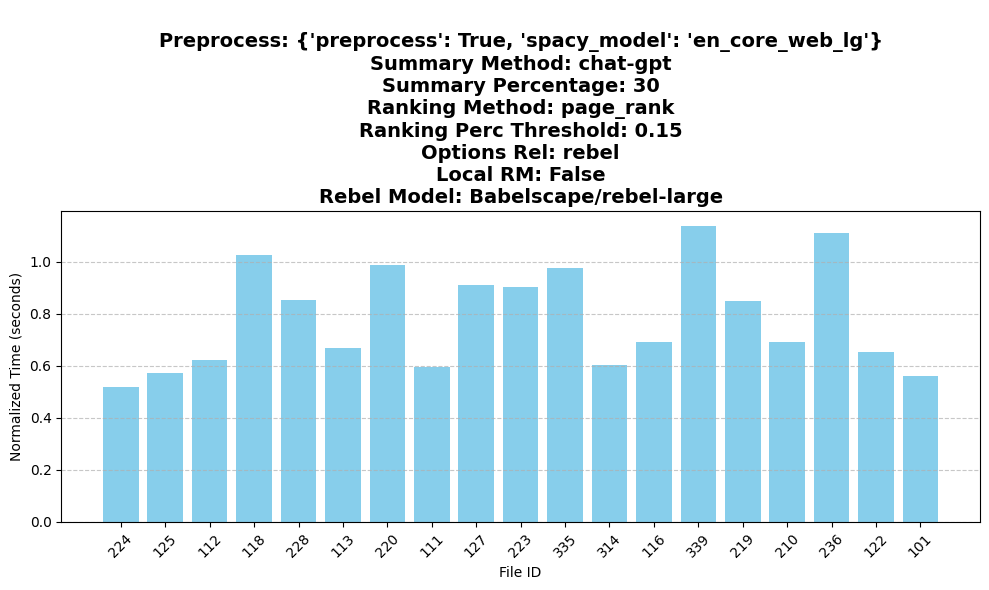

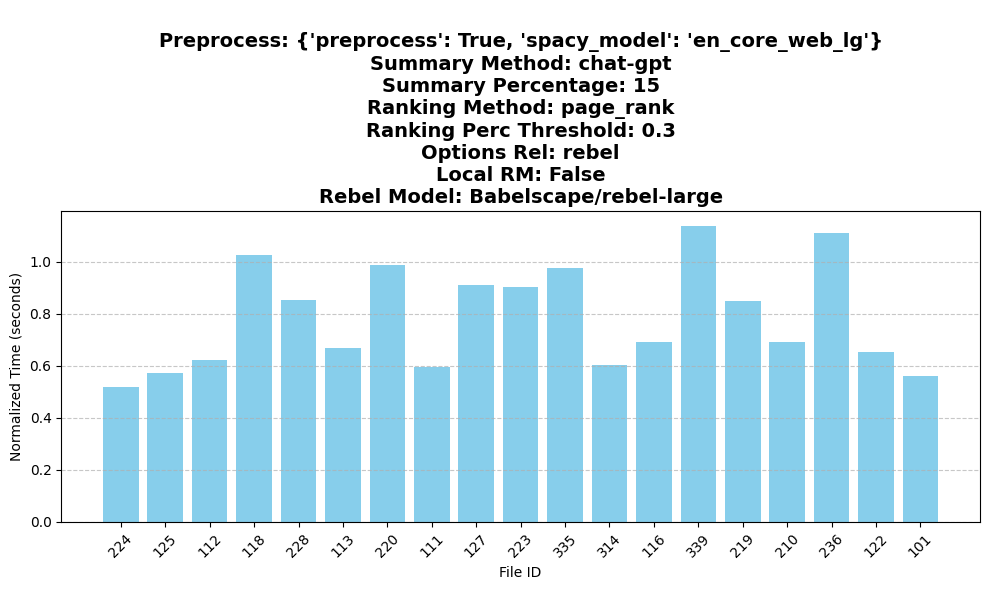

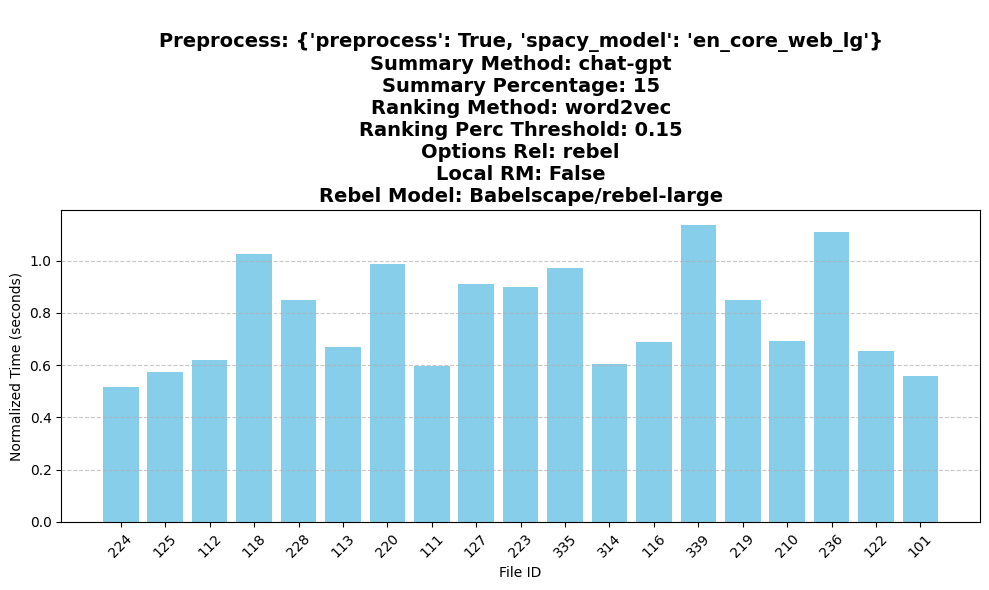

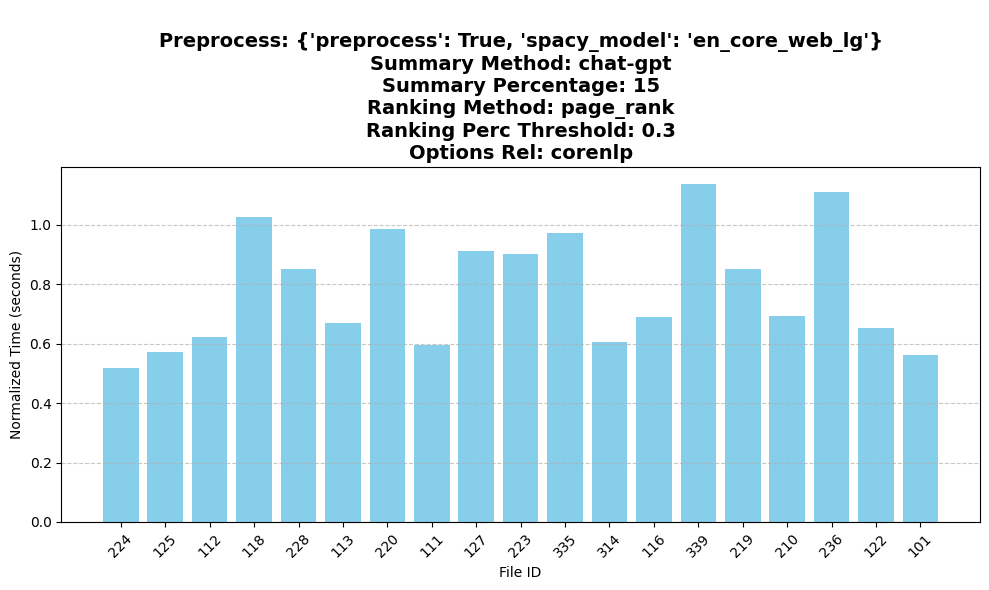

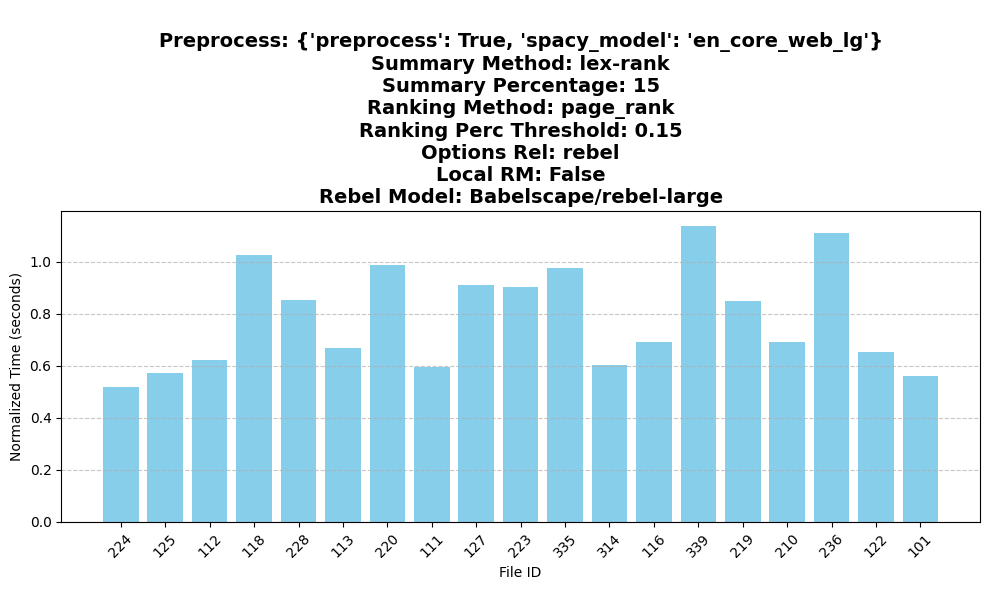

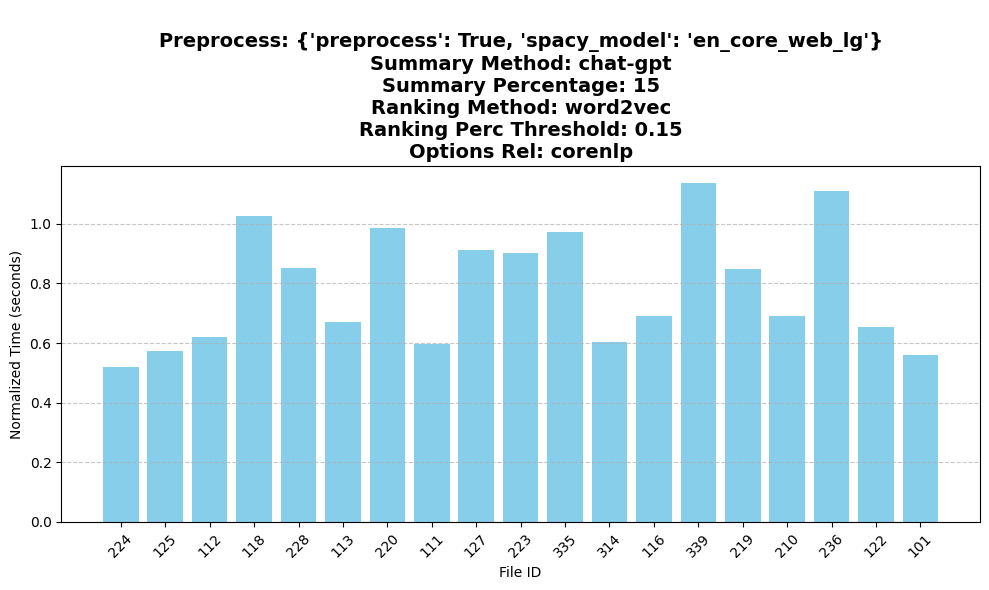

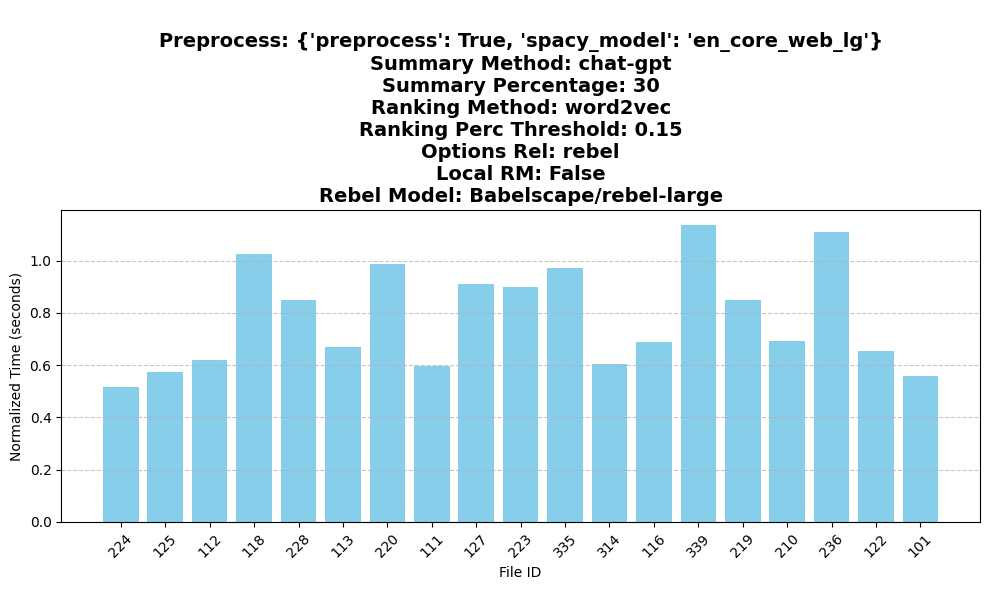

In [4]:
# Usage
root_dir = './experiments'
analyzer = MetricsAnalyzer(root_dir)
analyzer.analyze()